# Example: Compute the Price of an American Call and Put Option Contracts using CRR
In this example, we compare the prices of American call and put contracts using the Cox-Ross-Rubinstein (CRR) binomial model with what we observe in the market for AMD options contracts.

> __Learning Objectives:__
>
> By the end of this example, you should be able to:
> * __Build binomial tree models__ for equity price evolution using the Cox-Ross-Rubinstein (CRR) model to establish the foundation for American option pricing.
> * __Compute American option premiums__ using backward induction on CRR trees by evaluating the early exercise feature and working backward from expiration to the present time.
> * __Compare theoretical and market prices__ to identify mispriced contracts by computing CRR prices and evaluating them against observed bid-ask spreads.

Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> __Include:__ The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [1]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl).

### Data
To start, load the options data using [the `MyOptionsChainDataSet(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/data/#VLQuantitativeFinancePackage.MyOptionsChainDataSet) and store the data in the `metadata::Dict{String,Any}` and `optionschain::DataFrame` variables.

In [2]:
metadata, optionschain = let
    
    # initialize -
    options_dataset = MyOptionsChainDataSet(ticker="amd");
    metadata = options_dataset.metadata;
    optionschain = options_dataset.data;

    (metadata, optionschain) # return
end;

What's in the metadata dictionary?

In [3]:
metadata |> keys

KeySet for a Dict{String, Any} with 10 entries. Keys:
  "DTE"
  "purchase_date"
  "historical_volatility"
  "underlying_share_price_ask"
  "source"
  "underlying_share_price_bid"
  "is_weekly"
  "atm_IV"
  "expiration_date"
  "underlying_share_price_mid"

What about the optionschain variable?

In [4]:
optionschain

Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,Open Int,IV,Delta,Type
,Float64,Float64,Float64,Float64,Float64,Float64,String7,String7,Float64,Float64,String7
1,25.0,0.8907,203.1,204.0,204.9,209.72,0,419,2.1122,0.9989,Call
2,30.0,0.8688,198.2,199.05,199.9,206.3,0,163,1.9784,0.9985,Call
3,35.0,0.847,193.2,193.98,194.75,199.75,0,17,0.0,0.0,Call
4,40.0,0.8251,188.3,189.1,189.9,176.24,0,18,1.6654,0.9985,Call
5,45.0,0.8033,183.25,184.13,185.0,174.11,0,318,1.5375,0.9985,Call
6,50.0,0.7814,178.4,179.1,179.8,167.46,0,691,1.2356,0.9996,Call
7,55.0,0.7596,173.35,174.13,174.9,177.43,0,176,1.0885,0.9998,Call
8,60.0,0.7377,168.5,169.3,170.1,162.15,0,332,1.3802,0.9967,Call
9,65.0,0.7158,163.45,164.33,165.2,175.38,0,180,1.2927,0.9967,Call


### Constants
Finally, let's set some constants we'll use later in this notebook. The comments describe the constants, their units, and permissible values:

In [5]:
Sₒ = metadata["underlying_share_price_mid"] |> x-> parse(Float64,x); # set the initial share price (this has no importance now because we have the options chain data)
DTE = metadata["DTE"] |> x-> parse(Float64,x); # set the days to expiration
Δt = (1/365); # natural time-scale is days
T = (DTE) * Δt; # days to the expiration of the contract
r̄ = 0.040; # risk-free rate
h = 5*DTE |> Int64; # number of levels of the tree, n-points per day

___

## Task 1: Compute the Price of American Call Contracts
In this task, we'll compute the price of American call contracts using the CRR binomial model written against [Advanced Micro Devices, Inc. (AMD)](https://finance.yahoo.com/quote/AMD/).

Let's start by filtering the options chain data for call contracts, then we'll compute the price of each contract using the CRR binomial model. We'll use [the `filter(...)` function](https://dataframes.juliadata.org/stable/lib/functions/#Base.filter) to filter out the call contracts from the `optionschain` DataFrame.

In [6]:
call_contract_data = filter(row -> row[:Type] == "Call", optionschain)

Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,Open Int,IV,Delta,Type
,Float64,Float64,Float64,Float64,Float64,Float64,String7,String7,Float64,Float64,String7
1,25.0,0.8907,203.1,204.0,204.9,209.72,0,419,2.1122,0.9989,Call
2,30.0,0.8688,198.2,199.05,199.9,206.3,0,163,1.9784,0.9985,Call
3,35.0,0.847,193.2,193.98,194.75,199.75,0,17,0.0,0.0,Call
4,40.0,0.8251,188.3,189.1,189.9,176.24,0,18,1.6654,0.9985,Call
5,45.0,0.8033,183.25,184.13,185.0,174.11,0,318,1.5375,0.9985,Call
6,50.0,0.7814,178.4,179.1,179.8,167.46,0,691,1.2356,0.9996,Call
7,55.0,0.7596,173.35,174.13,174.9,177.43,0,176,1.0885,0.9998,Call
8,60.0,0.7377,168.5,169.3,170.1,162.15,0,332,1.3802,0.9967,Call
9,65.0,0.7158,163.45,164.33,165.2,175.38,0,180,1.2927,0.9967,Call


Next, we'll process each contract in the `call_contract_data::DataFrame` collection to compute its price using the CRR binomial model. We'll use a loop to iterate through each row of the DataFrame and apply the CRR pricing function to each contract's specific parameters (strike price, time to expiration, implied volatility, etc.).

We'll save the strike price, the observed price, and the computed price for each contract in the `call_contract_price_df::DataFrame` for later analysis.

__Strategy:__
For each contract in `call_contract_data::DataFrame,` get the `strike,` `IV,` `Bid,` and `Ask` values, and use these parameters (along with the current share price) to construct [an `MyAdjacencyBasedCRREquityPriceTree`](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.MyAdjacencyBasedCRREquityPriceTree) and [`MyAmericanCallContractModel`](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.MyAmericanCallContractModel) instances. 
* Use [the `premium(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.premium) to compute the premium (price) of each option contract.
* Populate records in the `call_contract_price_df::DataFrame,` assuming we capture the strike `K,` `bid,` `ask,` the computed premium, and a `mispriced::Bool` field. The `mispriced::Bool` field holds a `true|false` value indicating if the predicted contract price lies within the range $\left(1-\delta\right)\cdot\text{Bid}\leq\mathcal{P}_{p}\leq\left(1+\delta\right)\cdot\text{Ask}$, where the error margin is taken to be $\delta\sim{1\%}$.
* `Technical issue`: there are missing `IV` values in the `dataset` (listed as `0` values), leading to `false positive` pricing errors. Check for this condition, and set the missing `IV` values to some small value $\epsilon\sim{0.001}$.

So what do we get?

In [7]:
call_contract_price_df = let

    # initialize -
    data = call_contract_data;
    number_of_contracts = nrow(data);
    call_contract_price_df = DataFrame(); # strike price, IV, observed (mid) price, computed price
    θ = 1; # for premium calculations, we *always* set this to a log position
    δ = 0.15; # error margin for mispricing

    for i ∈ 1:number_of_contracts
        
        # get data from the contract -
        K = data[i,:Strike]; # strike price
        mid = filter([:Strike,:Type] => (x,y) -> (x == K && y == "Call"), data)[1,:Mid];
        bid = filter([:Strike,:Type] => (x,y) -> (x == K && y == "Call"), data)[1,:Bid];
        ask = filter([:Strike,:Type] => (x,y) -> (x == K && y == "Call"), data)[1,:Ask];

        IV = data[i,:IV]; # implied volatility
        if (IV ≤ 0.001)
            IV = 0.001;
        end

        # build the model -
        contract_model = build(MyAmericanCallContractModel, (
            K = K, premium = 0.0, sense = θ, copy = 1
        ));

        # build the tree for a contract i. Note the two step process: first we build an (empty) tree structure, then we populate it with future share price data
        tree_model = build(MyAdjacencyBasedCRREquityPriceTree, 
            (μ = r̄, T = T, σ = IV)) |> (x-> populate(x, Sₒ = Sₒ, h = h));

        # compute the premium for a contract i
        𝒫 = premium(contract_model, tree_model); # this method is doing the backward induction on the CRR tree

        # populate the data frame -
        row = (
            K = K,
            IV = IV,
            mid = mid,
            bid = bid,
            ask = ask,
            computed = 𝒫,
            mispriced = !(((1-δ)*bid <= 𝒫) && (𝒫 <= (1+δ)*ask))
        );
        push!(call_contract_price_df, row);
    end

    call_contract_price_df # return the data frame
end;

So what do we see?

In [8]:
call_contract_price_df

Row,K,IV,mid,bid,ask,computed,mispriced
,Float64,Float64,Float64,Float64,Float64,Float64,Bool
1,25.0,2.1122,204.0,203.1,204.9,201.0,false
2,30.0,1.9784,199.05,198.2,199.9,196.1,false
3,35.0,0.001,193.98,193.2,194.75,191.0,false
4,40.0,1.6654,189.1,188.3,189.9,186.1,false
5,45.0,1.5375,184.13,183.25,185.0,181.1,false
6,50.0,1.2356,179.1,178.4,179.8,176.1,false
7,55.0,1.0885,174.13,173.35,174.9,171.1,false
8,60.0,1.3802,169.3,168.5,170.1,166.3,false
9,65.0,1.2927,164.33,163.45,165.2,161.3,false


### Visualize
You'll notice that we have some mispriced contracts according to our CRR model. Let's visualize the results to see how well our computed prices match the market prices.

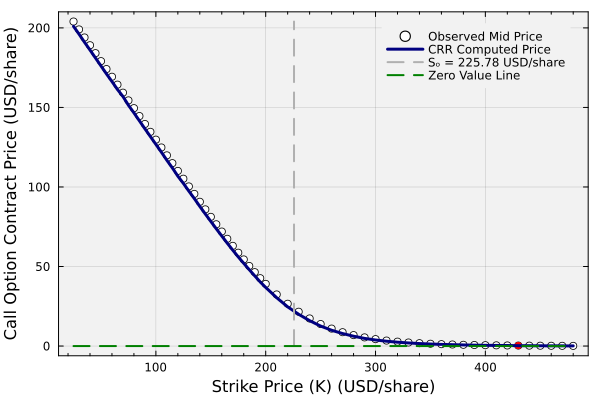

In [9]:
let
    # initialize -
    data = call_contract_data;
    number_of_contracts = nrow(data);
    number_of_steps = 100;
    q = plot();

    # plot the observed mid prices -
    scatter!(
        call_contract_price_df[:,:K], call_contract_price_df[:,:mid],
        label="Observed Mid Price", color=:white, ms=4, markershape=:circle
    );

    for i ∈ 1:number_of_contracts
        
        mispriced_flag = call_contract_price_df[i,:mispriced];
        if (mispriced_flag == true)
            scatter!(
                [call_contract_price_df[i,:K]], [call_contract_price_df[i,:mid]],
                markershape=:circle, msc=:red, c=:red,label="", ms=4,
            );
        end
    end

    plot!(
        call_contract_price_df[:,:K], call_contract_price_df[:,:computed],
        label="CRR Computed Price", color=:navy, lw=3, xminorticks=true
    )

    # current share price line -
    VLINE = zeros(number_of_steps, 2)
    VLINE[:,1] .= Sₒ*ones(number_of_steps)
    VLINE[:,2] .= range(0, stop = maximum(call_contract_price_df[:,:mid]), length = number_of_steps) |> collect;
    plot!(VLINE[:,1], VLINE[:,2], lw=2, c= :gray69, ls=:dash, label="Sₒ = $(Sₒ) USD/share")

    # zero value line -
    BEL = zeros(number_of_contracts);
    plot!(call_contract_price_df[:,:K], BEL, lw=2, c=:green, ls=:dash, label="Zero Value Line")
    
    xlabel!("Strike Price (K) (USD/share)");
    ylabel!("Call Option Contract Price (USD/share)");

    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);  

end

### Discussion
* Why does the premium of a __call option__ contract increase as $K\rightarrow{0}$ for $S_{0}$ = 225.78 USD/share? For example, what could you do if you purchased a call with a strike of $K=140$ USD/share?
___

## Task 2: Compute the Price of American Put Contracts
In this task, we'll compute the price of American put contracts using the CRR binomial model written against [Advanced Micro Devices, Inc. (AMD)](https://finance.yahoo.com/quote/AMD/). We will follow a similar approach as in Task 1, but this time focusing on put contracts.

Let's start by filtering the options chain data for put contracts, then we'll compute the price of each contract using the CRR binomial model. We'll use [the `filter(...)` function](https://dataframes.juliadata.org/stable/lib/functions/#Base.filter) to filter out the put contracts from the `optionschain` DataFrame.

In [10]:
put_contract_data = filter(row -> row[:Type] == "Put", optionschain)

Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,Open Int,IV,Delta,Type
,Float64,Float64,Float64,Float64,Float64,Float64,String7,String7,Float64,Float64,String7
1,25.0,-0.8907,0.0,0.02,0.03,0.02,0,"3,137",1.9233,-0.0005,Put
2,30.0,-0.8688,0.0,0.01,0.01,0.02,0,741,1.6054,-0.0002,Put
3,35.0,-0.847,0.0,0.01,0.01,0.02,0,252,1.4834,-0.0003,Put
4,40.0,-0.8251,0.0,0.02,0.04,0.01,0,"2,119",1.5545,-0.0009,Put
5,45.0,-0.8033,0.01,0.03,0.04,0.01,2,"1,031",1.2863,-0.0003,Put
6,50.0,-0.7814,0.01,0.03,0.05,0.01,244,"1,033",1.2042,-0.0003,Put
7,55.0,-0.7596,0.02,0.04,0.06,0.06,10,"1,173",1.3273,-0.0015,Put
8,60.0,-0.7377,0.03,0.05,0.07,0.04,58,"3,006",1.1994,-0.0011,Put
9,65.0,-0.7158,0.05,0.06,0.07,0.06,0,"2,959",1.1765,-0.0017,Put


Next, we'll process each contract in the `put_contract_data::DataFrame` collection to compute its price using the CRR binomial model. We'll use a loop to iterate through each row of the DataFrame and apply the CRR pricing function to each contract's specific parameters (strike price, time to expiration, implied volatility, etc.).

We'll save the strike price, the observed price, and the computed price for each contract in the `put_contract_price_df::DataFrame` for later analysis. We'll use the same strategy as in Task 1, but this time for put contracts.

In [11]:
put_contract_price_df = let

    # initialize -
    data = put_contract_data;
    number_of_contracts = nrow(data);
    put_contract_price_df = DataFrame(); # strike price, IV, observed (mid) price, computed price
    θ = 1; # for premium calculations, we *always* set this to a log position
    δ = 0.15; # error margin for mispricing

    for i ∈ 1:number_of_contracts
        
        # get data from the contract -
        K = data[i,:Strike]; # strike price
        mid = filter([:Strike,:Type] => (x,y) -> (x == K && y == "Put"), data)[1,:Mid];
        bid = filter([:Strike,:Type] => (x,y) -> (x == K && y == "Put"), data)[1,:Bid];
        ask = filter([:Strike,:Type] => (x,y) -> (x == K && y == "Put"), data)[1,:Ask];

        IV = data[i,:IV]; # implied volatility
        if (IV ≤ 0.001)
            IV = 0.001;
        end

        # build the model - use the put contract model
        contract_model = build(MyAmericanPutContractModel, (
            K = K, premium = 0.0, sense = θ, copy = 1
        ));

        # build the tree for a contract i. Note the two step process: first we build an (empty) tree structure, then we populate it with future share price data
        tree_model = build(MyAdjacencyBasedCRREquityPriceTree, 
            (μ = r̄, T = T, σ = IV)) |> (x-> populate(x, Sₒ = Sₒ, h = h));

        # compute the premium for a contract i
        𝒫 = premium(contract_model, tree_model); # this method is doing the backward induction on the CRR tree

        # populate the data frame -
        row = (
            K = K,
            IV = IV,
            mid = mid,
            bid = bid,
            ask = ask,
            computed = 𝒫,
            mispriced = !(((1-δ)*bid <= 𝒫) && (𝒫 <= (1+δ)*ask))
        );
        push!(put_contract_price_df, row);
    end

    put_contract_price_df # return the data frame
end;

So what do we see?

In [12]:
put_contract_price_df

Row,K,IV,mid,bid,ask,computed,mispriced
,Float64,Float64,Float64,Float64,Float64,Float64,Bool
1,25.0,1.9233,0.02,0.0,0.03,0.0309,false
2,30.0,1.6054,0.01,0.0,0.01,0.01026,false
3,35.0,1.4834,0.01,0.0,0.01,0.01034,false
4,40.0,1.5545,0.02,0.0,0.04,0.04164,false
5,45.0,1.2863,0.03,0.01,0.04,0.01051,false
6,50.0,1.2042,0.03,0.01,0.05,0.01059,false
7,55.0,1.3273,0.04,0.02,0.06,0.06347,false
8,60.0,1.1994,0.05,0.03,0.07,0.04275,false
9,65.0,1.1765,0.06,0.05,0.07,0.06429,false


### Visualize
You'll notice that we have some mispriced contracts according to our CRR model. Let's visualize the results to see how well our computed prices match the market prices.

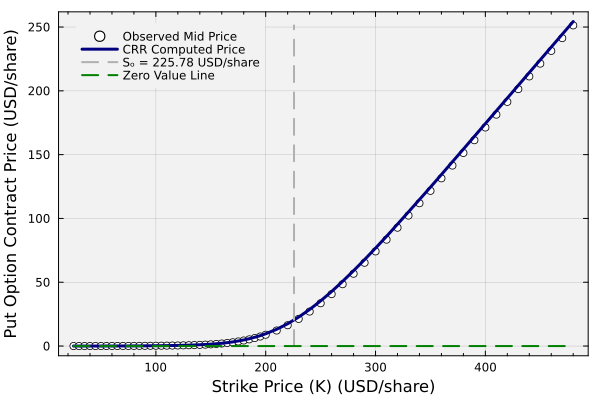

In [13]:
let
    # initialize -
    data = put_contract_price_df;
    number_of_contracts = nrow(data);
    number_of_steps = 100;
    θ = 1; # for premium calculations, we *always* set this to a log position
    q = plot();

    # plot the observed mid prices -
    scatter!(
        data[:,:K], data[:,:mid],
        label="Observed Mid Price", color=:white, ms=4, markershape=:circle
    );

    for i ∈ 1:number_of_contracts
        
        mispriced_flag = data[i,:mispriced];
        if (mispriced_flag == true)
            scatter!(
                [data[i,:K]], [data[i,:mid]],
                markershape=:circle, msc=:red, c=:red,label="", ms=4,
            );
        end
    end

    plot!(
        data[:,:K], data[:,:computed],
        label="CRR Computed Price", color=:navy, lw=3, xminorticks=true
    )

    # current share price line -
    VLINE = zeros(number_of_steps, 2)
    VLINE[:,1] .= Sₒ*ones(number_of_steps)
    VLINE[:,2] .= range(0, stop = maximum(data[:,:mid]), length = number_of_steps) |> collect;
    plot!(VLINE[:,1], VLINE[:,2], lw=2, c= :gray69, ls=:dash, label="Sₒ = $(Sₒ) USD/share")

    # zero value line -
    BEL = zeros(number_of_contracts);
    plot!(data[:,:K], BEL, lw=2, c=:green, ls=:dash, label="Zero Value Line")
    
    xlabel!("Strike Price (K) (USD/share)");
    ylabel!("Put Option Contract Price (USD/share)");

    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);  

end

### Discussion
* Why does the premium of a __put option contract__ increase as $K\rightarrow{\infty}$ for $S_{0}$ = 225.78 USD/share? For example, what could you do if you purchased a put with a strike of $K=400$ USD/share?
___

## Summary
This example demonstrates how the Cox-Ross-Rubinstein binomial model prices American options by building equity price trees and evaluating contracts at each node.

> __Key Takeaways:__
>
> * __Binomial trees model price paths:__ The CRR binomial model creates a discrete lattice of possible future equity prices, with parameters chosen to match the continuous lognormal distribution. Building and populating these trees provides the foundation for option pricing calculations.
> * __Backward induction computes American premiums:__ American option prices are calculated by working backward from expiration through the tree, evaluating at each node whether early exercise is optimal, comparing the immediate exercise value to the expected continuation value.
> * __Market prices reveal mispricings:__ Comparing CRR theoretical prices against observed market bid-ask spreads identifies contracts that may be overpriced or underpriced relative to the model, highlighting potential trading opportunities or hedging advantages.

Understanding how the binomial model values American options provides insight into the relationship between option prices, volatility, and time to expiration.
___

## Disclaimer and Risks

__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team.

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance. Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.